In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
from glob import glob
import sys
import random

from tqdm import tqdm_notebook
from skimage.io import imread, imshow
from skimage.transform import resize

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
from torch.autograd import Variable

from pathlib import Path

## Get paths for images and sort them

In [2]:

path = 'data/DRIVE/'
path_test = 'test/images'
path_test_mask = 'test/1st_manual'
path_train = 'training/images_gray'
path_train_mask = 'training/manual'

img_path = Path(os.path.join(path, path_train))
mask_path = Path(os.path.join(path, path_train_mask))
test_img_path = Path(os.path.join(path, path_test))
test_mask_path = Path(os.path.join(path, path_test_mask))

#sort images to line up train and mask
img_names = []
mask_names = []
test_img_names = []
test_mask_names = []
for img, mas, test_img, test_mask in zip(img_path.iterdir(), mask_path.iterdir(),
                                         test_img_path.iterdir(),
                                         test_mask_path.iterdir()):
    img_names.append(str(img))
    mask_names.append(str(mas))
    test_img_names.append(str(test_img))
    test_mask_names.append(str(test_mask))
    
mask_names.sort()
img_names.sort()
test_img_names.sort()
test_mask_names.sort()

In [3]:
len(test_img_names)

20

(584, 565)
(584, 565)


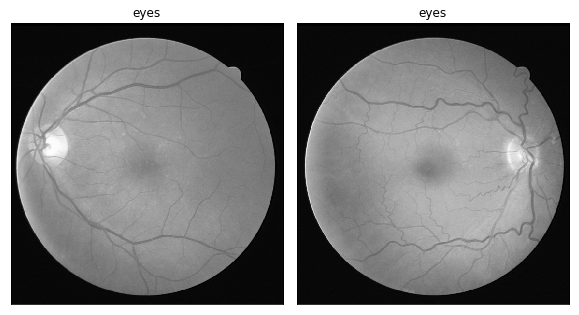

(584, 565)
(584, 565)


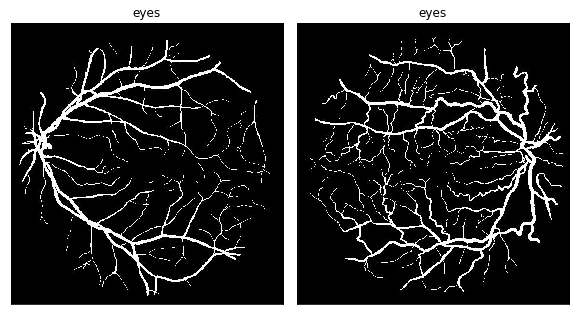

In [4]:
##show first two images 
def showImg(p):
    fig, axes = plt.subplots(1, 2, figsize=(10,10),
                         subplot_kw={'xticks': [], 'yticks': []})
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    for ax, i in zip(axes.flat, range(2)):
        img = imread(p[i])
        ax.imshow(img, cmap='gray')
        ax.set_title('eyes')  
        print(img.shape)
    plt.show()
    
showImg(img_names)
showImg(mask_names)


### Resize and flip images

In [5]:
im_width = 560
im_height = 560
im_chan = 3
X_train = np.zeros((len(img_names)*3, im_height, im_width, 1), dtype=np.uint8)
Y_train = np.zeros((len(img_names)*3, im_height, im_width, 1), dtype=np.bool_)
X_test = np.zeros((len(img_names), im_height, im_width, 1), dtype=np.uint8)

print('Getting and resizing train images and masks ... ')
sys.stdout.flush()

counter = 0
for i in tqdm_notebook(range(len(img_names))):
    img = imread(img_names[i])
    x = resize(img, (im_height, im_width, 1), mode='constant', preserve_range=True)
    X_train[counter] = x
     
    mask = imread(mask_names[i])
    m_ = np.zeros_like(mask)
    for k in range(584):
        for j in range(564):
            if mask[k][j]>50 :
                m_[k][j] = 1
    
    mask = resize(m_, (im_height, im_width, 1), mode='constant', preserve_range=True) 
    Y_train[counter] = mask    
    counter += 1
    
    #mod image and mask together
    X_train[counter] = np.fliplr(x)
    Y_train[counter] = np.fliplr(mask)
    
    counter +=1
    
    X_train[counter] = np.flipud(x)
    Y_train[counter] = np.flipud(mask)    
    counter +=1
    
    #resize for test images
    test_img = imread(test_img_names[i])
    test_img = resize(test_img, (im_height, im_width, 1), mode='constant', preserve_range=True)
    X_test[i] = test_img
   
print('Done!')

Getting and resizing train images and masks ... 


/home/tony/anaconda3/envs/torch/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/tony/anaconda3/envs/torch/lib/python3.7/site-packages/skimage/external/tifffile/tifffile.py:2611: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)



Done!


In [6]:
X_train[0].shape

(560, 560, 1)

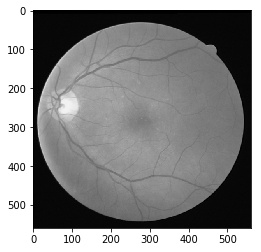

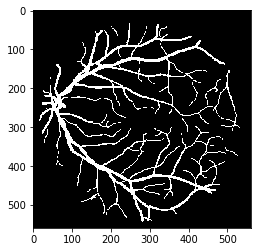

In [7]:
#resized images
ix = 0
plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
plt.show()
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

### Create dataset

In [8]:
class eye_dataset(torch.utils.data.Dataset):

    def __init__(self,preprocessed_images, train=True, preprocessed_masks=None):
        """
        Args:
            text_file(string): path to text file
            root_dir(string): directory with all train images
        """
        self.train = train
        self.images = preprocessed_images
        if self.train:
            self.masks = preprocessed_masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = None
        if self.train:
            mask = self.masks[idx]
            return (image, mask)
        return image

In [9]:
X_train[0].shape

(560, 560, 1)

In [10]:
#reshape
X_train_shaped = X_train.reshape(-1, 1, 560, 560)/255
Y_train_shaped = Y_train.reshape(-1, 1, 560, 560)

X_test_shaped = X_test.reshape(-1,1, 560, 560)/255

In [11]:
X_train_shaped = X_train_shaped.astype(np.float32)
Y_train_shaped = Y_train_shaped.astype(np.float32)

X_test_shaped = X_test_shaped.astype(np.float32)

In [12]:
X_train_shaped[0].shape

(1, 560, 560)

In [13]:
X_test_shaped[0].shape

(1, 560, 560)

In [14]:
#split
idx = list(range(60))
train_idxs = idx[:48]
val_idxs = idx[48:]
test_idx = list(range(1))

In [15]:
val_idxs

[48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]

In [15]:
eye_dataset_train = eye_dataset(X_train_shaped[train_idxs], 
                                      train=True, 
                                      preprocessed_masks=Y_train_shaped[train_idxs])
eye_dataset_val = eye_dataset(X_train_shaped[val_idxs], 
                                      train=True, 
                                      preprocessed_masks=Y_train_shaped[val_idxs])

eye_test_dataset = eye_dataset(X_test_shaped[test_idx], train=False)

batch_size = 1

train_loader = torch.utils.data.DataLoader(dataset=eye_dataset_train, 
                                           batch_size=batch_size, 
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=eye_dataset_val, 
                                           batch_size=batch_size, 
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=eye_test_dataset, batch_size=1,
                                         shuffle=False)

In [16]:
def conv_layer(chanIn, chanOut, ks = 3, stride=1):
    return nn.Sequential(
        nn.Conv2d(chanIn, chanOut, ks, stride, padding=1),
        nn.BatchNorm2d(chanOut),
        nn.ReLU(inplace=True)
    )

def conv_dilated(chanIn, chanOut, ks = 3, stride=1, dilation=1):
    return nn.Sequential(
        nn.BatchNorm2d(chanIn),
        nn.ReLU(inplace=True),
        nn.Conv2d(chanIn, chanOut, ks, stride, dilation=dilation, padding=1)    
    )


class Conv_block(nn.Module):
    def __init__(self, chanIn, chanOut, dilation=1):
        super().__init__()
        
        self.conv1 = conv_dilated(chanIn, chanOut)
        self.conv2 = conv_dilated(chanOut, chanOut)
        
    def forward(self, x) : 
        x = self.conv1(x)
        x = self.conv2(x)
        return x
        

class Res_Block(nn.Module):
    def __init__(self):
        super(Res_Block, self).__init__()
        
        self.init_L = conv_layer(1,16)
        
        self.group1_1 = Conv_block(16,16,1)
        self.group1_2 = Conv_block(32,16,1)
        self.group1_3 = Conv_block(48,16,1)
        
        self.group2_1 = Conv_block(64,32,2)
        self.group2_2 = Conv_block(96,32,2)
        self.group2_3 = Conv_block(128,32,2)
        
        self.group3_1 = Conv_block(160,64,4)
        self.group3_2 = Conv_block(224,64,4)
        self.group3_3 = Conv_block(288,64,4)
        
        self.last = nn.Conv2d(352,1,1)
        
    def forward(self, x):
        x = self.init_L(x)
        
        xg1_1 = self.group1_1(x)
        cat1_1 = torch.cat([xg1_1,x],1)
        xg1_2 = self.group1_2(cat1_1)
        
        cat1_2 = torch.cat([xg1_2,cat1_1],1)
        
        xg1_3 =self.group1_3(cat1_2)
        cat1_3 = torch.cat([xg1_3,cat1_2],1)
        
        xg2_1 = self.group2_1(cat1_3)
        cat2_1 = torch.cat([xg2_1,cat1_3],1)
        xg2_2 = self.group2_2(cat2_1)
        cat2_2 = torch.cat([xg2_2,cat2_1],1)
        xg2_3 =self.group2_3(cat2_2)
        cat2_3 = torch.cat([xg2_3,cat2_2],1)
        
        xg3_1 = self.group3_1(cat2_3)
        cat3_1 = torch.cat([xg3_1,cat2_3],1)
        xg3_2 = self.group3_2(cat3_1)
        cat3_2 = torch.cat([xg3_2,cat3_1],1)
        xg3_3 =self.group3_3(cat3_2)
        cat3_3 = torch.cat([xg3_3,cat3_2],1)
        
        x = self.last(cat3_3)
        return x

In [18]:
model = Res_Block()
model.cuda();

criterion = nn.BCEWithLogitsLoss()

learning_rate = 0.01 #1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', 
                                                       factor=0.1, 
                                                       patience=9,
                                                       threshold=.000001, 
                                                       verbose=True)


In [19]:
mean_train_losses = []
mean_val_losses = []
for epoch in range(100):
    train_losses = []
    val_losses = []
    for images, masks in train_loader:        
        images = Variable(images.cuda())
        masks = Variable(masks.cuda())
        
        outputs = model(images)        
        
        loss = criterion(outputs, masks)
        train_losses.append(loss.data)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
    for images, masks in val_loader:
        images = Variable(images.cuda())
        masks = Variable(masks.cuda())
        
        outputs = model(images)
        loss = criterion(outputs, masks)
        val_losses.append(loss.data)
    
    
    mean_train_losses.append(np.mean(train_losses))
    mean_val_losses.append(np.mean(val_losses))
    scheduler.step(mean_val_losses[epoch])
    
    # Print Loss
    print('Epoch: {}. Train Loss: {}. Val Loss: {}'.format(epoch+1, np.mean(train_losses), np.mean(val_losses)))


Epoch: 1. Train Loss: 0.3467664420604706. Val Loss: 0.18011373281478882
Epoch: 2. Train Loss: 0.2045505791902542. Val Loss: 0.1499784290790558
Epoch: 3. Train Loss: 0.17698748409748077. Val Loss: 0.14077965915203094
Epoch: 4. Train Loss: 0.16576041281223297. Val Loss: 0.13781391084194183
Epoch: 5. Train Loss: 0.15500159561634064. Val Loss: 0.12661971151828766
Epoch: 6. Train Loss: 0.14947311580181122. Val Loss: 0.12754005193710327
Epoch: 7. Train Loss: 0.14933577179908752. Val Loss: 0.12811468541622162
Epoch: 8. Train Loss: 0.14617317914962769. Val Loss: 0.12298092991113663
Epoch: 9. Train Loss: 0.14360874891281128. Val Loss: 0.12586747109889984
Epoch: 10. Train Loss: 0.14597433805465698. Val Loss: 0.11633393913507462
Epoch: 11. Train Loss: 0.13677477836608887. Val Loss: 0.11744020134210587
Epoch: 12. Train Loss: 0.13740967214107513. Val Loss: 0.11584359407424927
Epoch: 13. Train Loss: 0.1348877102136612. Val Loss: 0.12224110960960388
Epoch: 14. Train Loss: 0.13276955485343933. Val Los

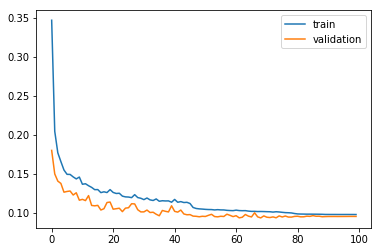

In [20]:
train_loss_series = pd.Series(mean_train_losses)
val_loss_series = pd.Series(mean_val_losses)
train_loss_series.plot(label="train")
val_loss_series.plot(label="validation")
plt.legend()

torch.save(model.state_dict(), 'data/eyeResults/res_dil_1.pth' )

In [ ]:
res = []
for im in test_loader:
    image = Variable(im.type(torch.FloatTensor).cuda())
    y_pred = model(image)
    res.append(y_pred)

In [22]:
res[0][0].shape

torch.Size([1, 560, 560])

In [23]:
result =res[0][0].reshape(560, 560,-1)

In [24]:
result.shape

torch.Size([560, 560, 1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


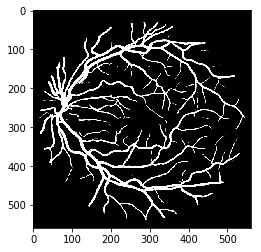

In [25]:
res1 = result.data.cpu().numpy()
res1 = np.squeeze(res1).astype(np.float32)
plt.imshow(np.dstack((res1,res1,res1)))

In [17]:
def res_show(img):
    result = img.reshape(560,560,-1)
    result = result.data.cpu().numpy()
    result = np.squeeze(result).astype(np.float32)
    x = resize(result, (584, 565, 1), mode='constant', preserve_range=True)
    x = np.squeeze(x).astype(np.float32)
    fig = plt.figure(figsize=(10,10))
    ax1 = fig.add_subplot(111)
    ax1.imshow(np.dstack((x,x,x)))
    plt.show()

#res_show(res[0][0])

In [18]:
model = Res_Block()
model.cuda()
state_dict = torch.load('data/eyeResults/res_dil_1.pth')
model.load_state_dict(state_dict)
model.eval()

Res_Block(
  (init_L): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (group1_1): Conv_block(
    (conv1): Sequential(
      (0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU(inplace)
      (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (conv2): Sequential(
      (0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU(inplace)
      (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (group1_2): Conv_block(
    (conv1): Sequential(
      (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU(inplace)
      (2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (conv2): Sequential(
      (0): BatchNorm2d

In [19]:
res = []
for im in test_loader:
    image = Variable(im.type(torch.FloatTensor).cuda())
    #image = image.unsqueeze(0)
    y_pred = model(image)
    res.append(y_pred)

/home/tony/anaconda3/envs/torch/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


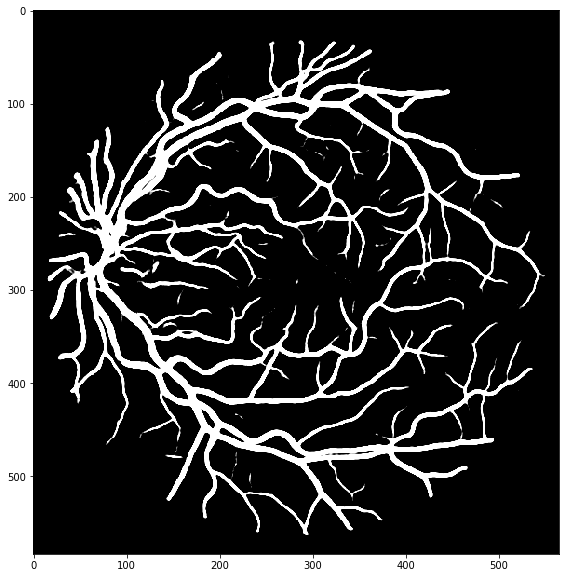

In [20]:
res_show(res[0][0])